### **ReAct Agent**

In [18]:
from typing import Annotated, List, Union, Literal 

from langchain_core.messages import ToolMessage 
from langchain_core.tools import InjectedToolCallId, tool 
from langgraph.prebuilt import InjectedState
from langgraph.types import Command
from utils import format_messages

In [19]:
@tool 
def calculator(
    operation: Literal["add", "subtract", "multiply", "divide"], 
    a: Union[int, float], 
    b: Union[int, float], 
) -> Union[int, float]:
    """
    Define a two input calculator tool that returns precise answers.
    Arg:
        operation(str): The Operation to perform. ("add", "subtract", "multiply", "divide")
        a (int or float): The First number
        b (int or float): The Second number
    Example:
        Divide: result = a / b 
        Subtract: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Division by zero is not allowed"}

    # Perform Calculation 
    if operation == "add":
        result = a + b 
    elif operation == "subtract":
        result = a - b 
    elif operation == "multiply":
        result = a * b 
    elif operation == "divide":
        result = a / b
    else:
        result = "Unknown Operation" 
    return result

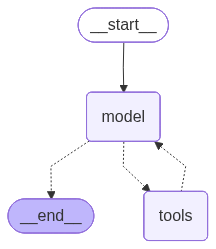

In [20]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model 
from langchain.agents import create_agent 
from langchain_openai import ChatOpenAI 
import os 
from dotenv import load_dotenv 
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") 

model = ChatOpenAI(model = 'gpt-3.5-turbo') 
tools = [calculator] 

SYSTEM_PROMPT = """
You are a helpful arithmetic assistant who is an expert at using a calculator. 
Return all text as plain text without Markdown math delimiters.
"""

# Create Agent 
agent = create_agent(
    model, 
    tools, 
    system_prompt=SYSTEM_PROMPT, 
).with_config({"recursion_limit": 20}) 

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [21]:
type(agent)

langgraph.graph.state.CompiledStateGraph

In [22]:
result = agent.invoke(
    {
        "messages": [
            {
                'role': 'user', 
                'content': 'What is 3.2 * 2.5 * 42 / 10.3'
            }
        ]
    }
)

In [24]:
format_messages(result["messages"])

┌───────────────────────────────── 🧑 Human ──────────────────────────────────┐
│ What is 3.2 * 2.5 * 42 / 10.3                                               │
└─────────────────────────────────────────────────────────────────────────────┘
┌─────────────────────────────────── 📝 AI ───────────────────────────────────┐
│                                                                             │
│                                                                             │
│ 🔧 Tool Call: calculator                                                    │
│    Args: {                                                                  │
│   "operation": "multiply",                                                  │
│   "a": 3.2,                                                                 │
│   "b": 2.5                                                                  │
│ }                                                                           │
│    ID: call_MOjDfQ7t6osM1SlmoJ1FHlUd     

In [13]:
result

{'messages': [HumanMessage(content='What is 3.2 * 2.5 * 42 / 10.3', additional_kwargs={}, response_metadata={}, id='fcd009e2-6bdb-4799-84d6-30cbfbeea978'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 188, 'total_tokens': 275, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-D8zC0Pt7hSK14Vq0VRaYLNetIw38i', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c59dd-943a-7070-9d7f-e63483aa028b-0', tool_calls=[{'name': 'calculator', 'args': {'operation': 'multiply', 'a': 3.2, 'b': 2.5}, 'id': 'call_seuiczldneByiAu1dKlon8Ut', 'type': 'tool_call'}, {'name': 'calculator', 'args': {'operation': 'multipl

In [17]:
print(result["messages"][-1].content)

The result of the expression \( 3.2 \times 2.5 \times 42 \div 10.3 \) is approximately 32.6214.


In [26]:
from IPython.display import JSON
from langchain_core.messages import messages_to_dict

JSON({"messages": messages_to_dict(result["messages"])})

<IPython.core.display.JSON object>

### **Custom State**

In [27]:
from langchain.agents import AgentState 

def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = [] 
    if not right:
        right = [] 
    return left + right 

class CalcState(AgentState):
    """Graph State."""
    ops: Annotated[List[str], reduce_list]

In [28]:
@tool 
def calculator_wstate(
    operation: Literal["add","subtract","multiply","divide"], 
    a: Union[int, float], 
    b: Union[int, float], 
    state: Annotated[CalcState, InjectedState], # not sent to LLM
    tool_call_id: Annotated[str, InjectedToolCallId] # not sent to LLM
) -> Union[int, float]:
    """Define a two-input calculator tool.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.
        
    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"

    ops = [f"({operation}, {a}, {b})"]
    return Command(
        update={
            "ops": ops,
            "messages": [
                ToolMessage(f"{result}", tool_call_id=tool_call_id)
            ],
        }
    )

In [29]:
SYSTEM_PROMPT = """
You are a helpful arithmetic assistant who is an expert at using a calculator. 
Return all text as plain text without Markdown math delimiters.
"""

model = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.0)
tools = [calculator_wstate]  # new tool

# Create agent
agent = create_agent(
    model,
    tools,
    system_prompt=SYSTEM_PROMPT,
    state_schema=CalcState,  # now defining state scheme
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

In [30]:
result2 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

format_messages(result2["messages"])

┌───────────────────────────────── 🧑 Human ──────────────────────────────────┐
│ What is 3.1 * 4.2?                                                          │
└─────────────────────────────────────────────────────────────────────────────┘
┌─────────────────────────────────── 📝 AI ───────────────────────────────────┐
│                                                                             │
│                                                                             │
│ 🔧 Tool Call: calculator_wstate                                             │
│    Args: {                                                                  │
│   "operation": "multiply",                                                  │
│   "a": 3.1,                                                                 │
│   "b": 4.2                                                                  │
│ }                                                                           │
│    ID: call_8yIhig5U77HgCEBBreAvmANK     

In [31]:
JSON(result2)

<IPython.core.display.JSON object>

In [32]:
result3 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2 + 5.5 * 6.5?",
            }
        ],
    }
)

format_messages(result3["messages"])

┌───────────────────────────────── 🧑 Human ──────────────────────────────────┐
│ What is 3.1 * 4.2 + 5.5 * 6.5?                                              │
└─────────────────────────────────────────────────────────────────────────────┘
┌─────────────────────────────────── 📝 AI ───────────────────────────────────┐
│                                                                             │
│                                                                             │
│ 🔧 Tool Call: calculator_wstate                                             │
│    Args: {                                                                  │
│   "operation": "multiply",                                                  │
│   "a": 3.1,                                                                 │
│   "b": 4.2                                                                  │
│ }                                                                           │
│    ID: call_KllBIOs3r6yjDsym8mfsiItg     